# Parameter test

New to active nematics FEM simulation, I want to figure out a set of parameters that can generate physical results, ideally in a short time frame. This involves testing running speed for different MPI processes and different mesh geometries, etc. In this notebook, these tests are planned and documented. 

## 0 Packages

In [3]:
import re
import numpy as np
import pandas as pd
import glob
import os
import psutil
import time
from pathlib import Path
from utils import *

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks


## 1 MPI process numbers

Parallel computing does not necessarily speed up the computation linearly. Actually, even speedup itself is not always guaranteed. This is due to the runtime overhead of the communication between processes. 

In this test, the number of processes `mpirun -n` parameter ranges from 1 to 9. The mesh being tested consists of ~4000 elements. Indeed, the linear speedup is not observed. Instead, we observe the shortest run time at $n=3$. The run time $T$ as a function of process number $n$ is plotted below. 

In [ ]:
folder = "/home/zhengyangliu/Documents/RATSIM/MPI_speed_test/"

with open(os.path.join(folder, "result.txt"), "r") as f:
    lines = f.readlines()
import time
data = []

for line in lines:
    match = re.search(r"n=(\d+): ([\d.]+) s", line)
    if match:
        n_value = int(match.group(1))
        s_value = float(match.group(2))
        data.append({"n": n_value, "T": s_value})

df = pd.DataFrame(data)

Text(0, 0.5, 'Run time, T (s)')

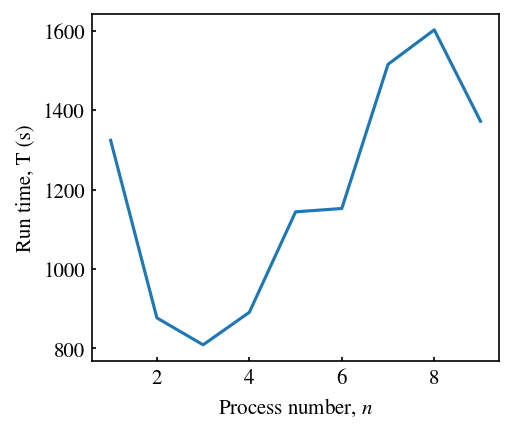

In [16]:
plt.figure(figsize=(3.5, 3), dpi=150)
plt.plot(df["n"], df["T"])
plt.xlabel("Process number, $n$")
plt.ylabel("Run time, T (s)")

## 2 Active length scale 

The equations we simulated are dimensionless, and the actual length scale in the system is somewhat obscure to me. It is desired to directly measure it in simulation in a simple domain. 

In this test, we run the simulation in a square domain 100 x 100. We vary the activity coefficient $\alpha\in[1, 2, 4, 8, 16, 32]$. We aim to observe the characteristic length scale in the resulting velocity field, which can guide our design of the ratchet channels, as well as anchor the simulation length scale to the real length scale. 

In [11]:
folder = Path("/home/zhengyangliu/Documents/RATSIM/alpha_length_scale")
save_folder = folder / "Correlation_length"
interval = 5
dt = 0.1

save_folder.mkdir(exist_ok=True)
alphas = [1, 2, 4, 8, 16, 32]
for alpha in alphas:
    v_list, domain = read_pvd(folder / f"alpha={alpha}" / "results.pvd", "Q")
    t_list = []
    cl_list = []
    for i, v in enumerate(v_list):
        if i % interval == 0:
            X, Y, U, V = interpolate_to_grid(v, domain, 5)
            cl, vacf = corr_length(X, Y, U, V)
            print(i, cl, end="\r")
            t_list.append(dt*i)
            cl_list.append(cl)
    df = pd.DataFrame({"t": t_list, "cl": cl_list})
    df.to_hdf(save_folder / f"alpha={alpha}.h5", "CL")

(0.0, 10.0)

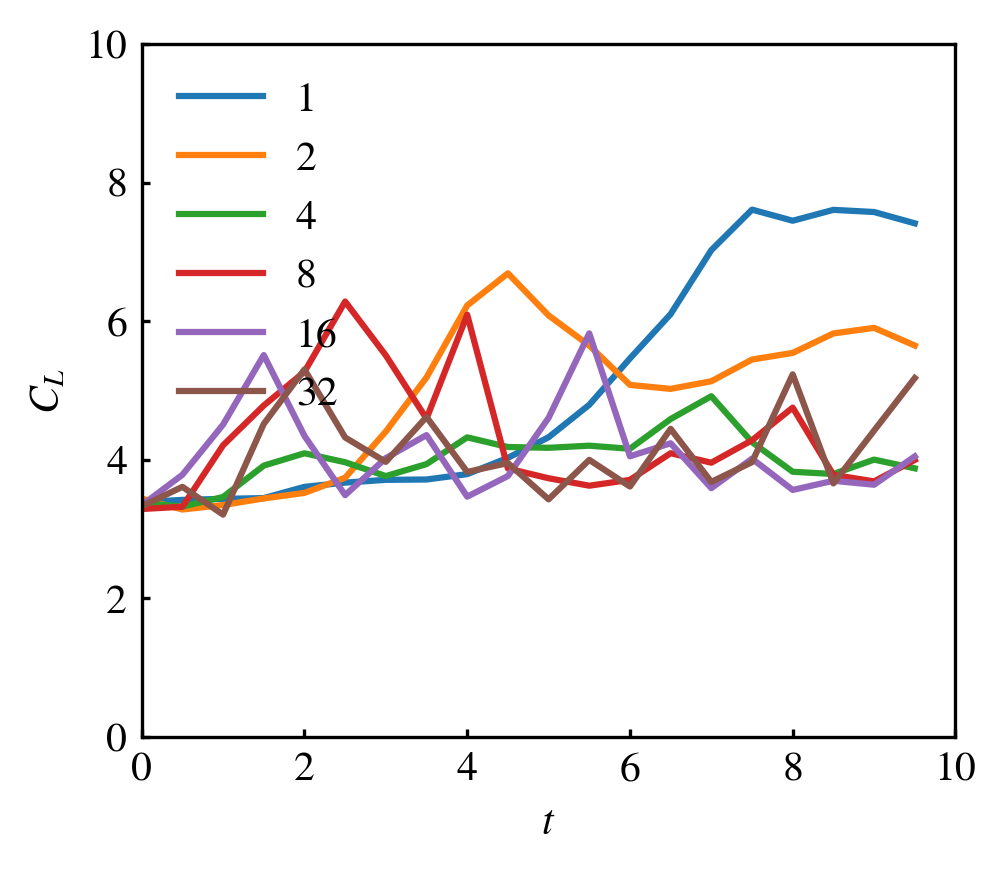

In [15]:
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)
for alpha in alphas:
    df = pd.read_hdf(save_folder  / f"alpha={alpha}.h5")
    ax.plot(df.t, df.cl, "-", label=alpha)
ax.set_xlabel("$t$")
ax.set_ylabel("$C_L$")
ax.legend(frameon=False)
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

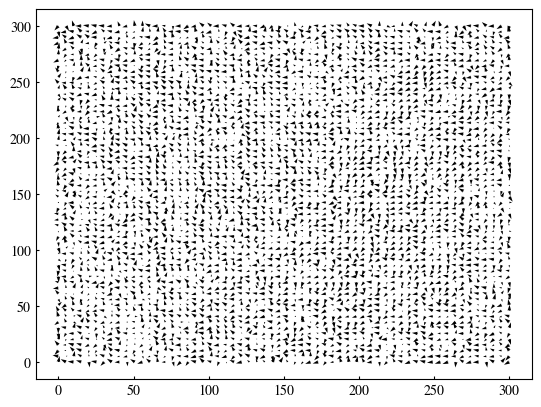

In [16]:
plt.quiver(X, Y, U, V)

## 3 CPU usage

In [6]:
def monitor_cpu_usage(interval=1, duration=60):
    """
    Monitors system-wide CPU usage and prints it to the console.

    Args:
        interval (int): The time interval (in seconds) between readings.
        duration (int): The total duration (in seconds) to monitor.
                        Set to 0 or a negative number for continuous monitoring
                        until the script is stopped manually (Ctrl+C).
    """
    print("--- CPU Usage Monitor ---")
    print(f"Monitoring every {interval} second(s).")
    if duration > 0:
        print(f"Total duration: {duration} seconds.")
    else:
        print("Monitoring continuously (Ctrl+C to stop).")
    print("-" * 30)

    start_time = time.time()
    try:
        while True:
            # psutil.cpu_percent() calculates the CPU utilization as a percentage.
            # The 'interval' argument makes it block for the specified seconds
            # and calculate the percentage over that interval.
            # The first call will return 0.0, so it's good to call it once
            # before the loop if you want to skip the initial 0.0 or
            # use a very small interval for the first meaningful reading.
            cpu_percent = psutil.cpu_percent(interval=interval)

            # psutil.cpu_percent(percpu=True) gives usage for each core
            # cpu_per_core = psutil.cpu_percent(interval=interval, percpu=True)

            print(f"CPU Usage: {cpu_percent:.1f}%")

            if duration > 0 and (time.time() - start_time) >= duration:
                break
    except KeyboardInterrupt:
        print("\nMonitoring stopped by user.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        print("--- Monitor Ended ---")

    # Example usage: Monitor for 30 seconds, updating every 2 seconds
    

    # Example usage: Monitor continuously (Ctrl+C to stop)
    # monitor_cpu_usage(interval=1, duration=0)

In [11]:
monitor_cpu_usage(interval=2, duration=30)

--- CPU Usage Monitor ---
Monitoring every 2 second(s).
Total duration: 30 seconds.
------------------------------
CPU Usage: 91.9%
CPU Usage: 97.5%
CPU Usage: 99.3%
CPU Usage: 95.0%
CPU Usage: 92.7%
CPU Usage: 94.6%
CPU Usage: 82.7%
CPU Usage: 76.1%
CPU Usage: 82.3%
CPU Usage: 83.1%
CPU Usage: 77.0%
CPU Usage: 76.3%
CPU Usage: 76.5%
CPU Usage: 75.9%
CPU Usage: 82.1%
--- Monitor Ended ---


When using `mpirun -n 2`, the CPU usage is typically around 20% and the computation speed was shown to be good. So we will proceed with $n=2$ in our following tests. 

## 4 Time step

In the previous tests, I always observe spurious boundary velocity fluctuation, which looks very unphysical. I remember having smoother velocity before, but could not figure out what is the key that gives me smooth velocity field. 

As a hypothesis, smaller time step is worth trying. In this section, we test $\Delta t\in [0.01, 0.02, 0.04, 0.08]$.

### 4.1 Correlation length

In [ ]:
folder = Path("/home/zhengyangliu/Documents/RATSIM/time_step")
save_folder = folder / "Correlation_length"
dts = [0.01, 0.02, 0.04, 0.08]
interval = 5
save_folder.mkdir(exist_ok=True)

for dt in dts:
    if dt == 0.01:
        continue-
    v_list, domain = read_pvd(folder / f"dt={dt:.2f}" / "results.pvd", "velocity")
    t_list = []
    cl_list = []
    for i, v in enumerate(v_list):
        if i % interval == 0:
            X, Y, U, V = interpolate_to_grid(v, domain, 5)
            cl, vacf = corr_length(X, Y, U, V)
            print(i, cl, end="\r")
            t_list.append(dt*i)
            cl_list.append(cl)
    df = pd.DataFrame({"t": t_list, "cl": cl_list})
    df.to_hdf(save_folder / f"dt={dt:.2f}.csv")

In [28]:
df = pd.read_hdf(save_folder / f"dt={dt:.2f}.h5")

(0.0, 50.0)

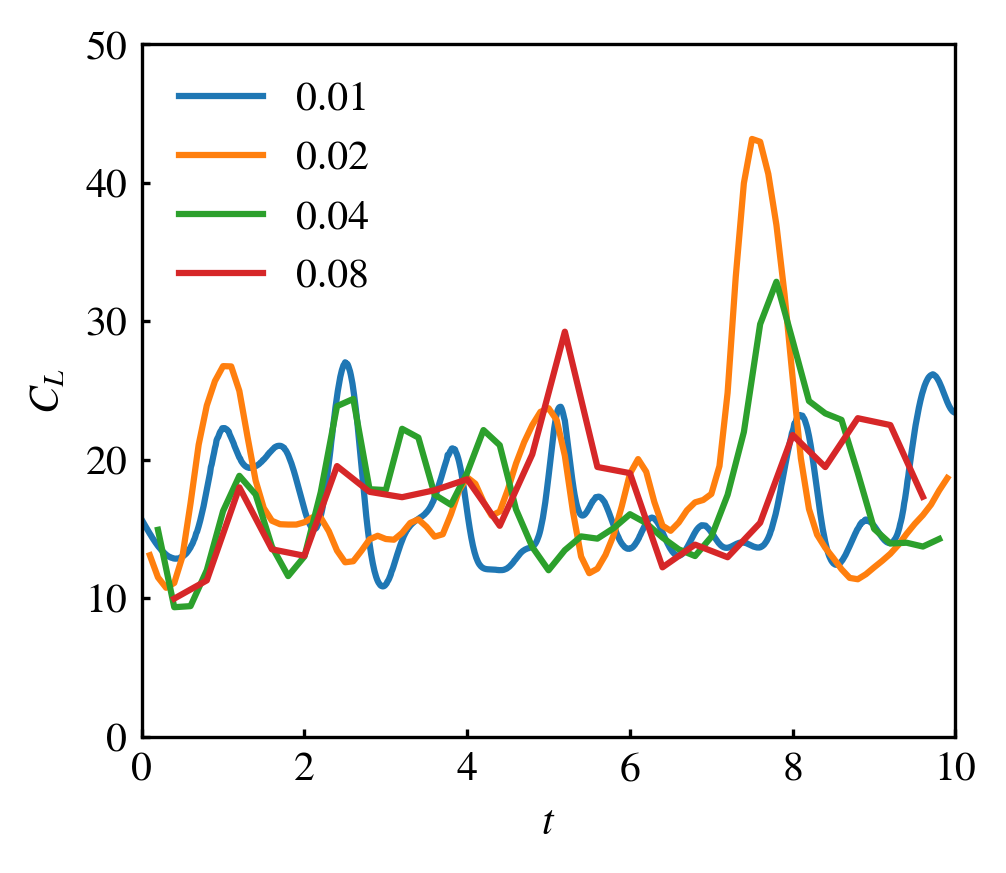

In [38]:
folder = Path("/home/zhengyangliu/Documents/RATSIM/time_step/Correlation_length")

fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)
for dt in dts:
    df = pd.read_hdf(folder / f"dt={dt:.2f}.h5")
    ax.plot(df.t, df.cl, "-", label=dt)
ax.set_xlabel("$t$")
ax.set_ylabel("$C_L$")
ax.legend(frameon=False)
ax.set_xlim(0, 10)
ax.set_ylim(0, 50)

## 5 System size

In this section, we try larger systems, ranging from 100 to 300. The goal is to see whether larger systems give rise to more random handness of the vorticity.

It turns out that the positive only vorticity is due to the fact that I chose to color the "magnitude" of the vorticity, instead of showing the values with sign. When switching to vorticity in Z, both handnesses appear with equal probability and intensity. So, there is no need to test the effect of the system size. 

On the other hand, we have found in the finer mesh test that, indeed, spatial correlation arises, much clearer than in coarse mesh runs, suggesting that we've identified the characteristic length scale of the problem.

## 6 Compare free-slip and no-slip

I noticed that the free-slip boundary condition I defined using the implicit method gives unphysical flow. In this section we compare the results of the two conditions. The conclusion is to keep using no-slip boundary. 

In [46]:
folder = Path("/home/zhengyangliu/Documents/RATSIM/compare_bcs")
# noslip
v_ns, domain_ns = read_pvd(folder / "noslip" / "results.pvd", "velocity")
v_fs, domain_fs = read_pvd(folder / "freeslip" / "results.pvd", "velocity")

Text(0.5, 1.0, 'freeslip')

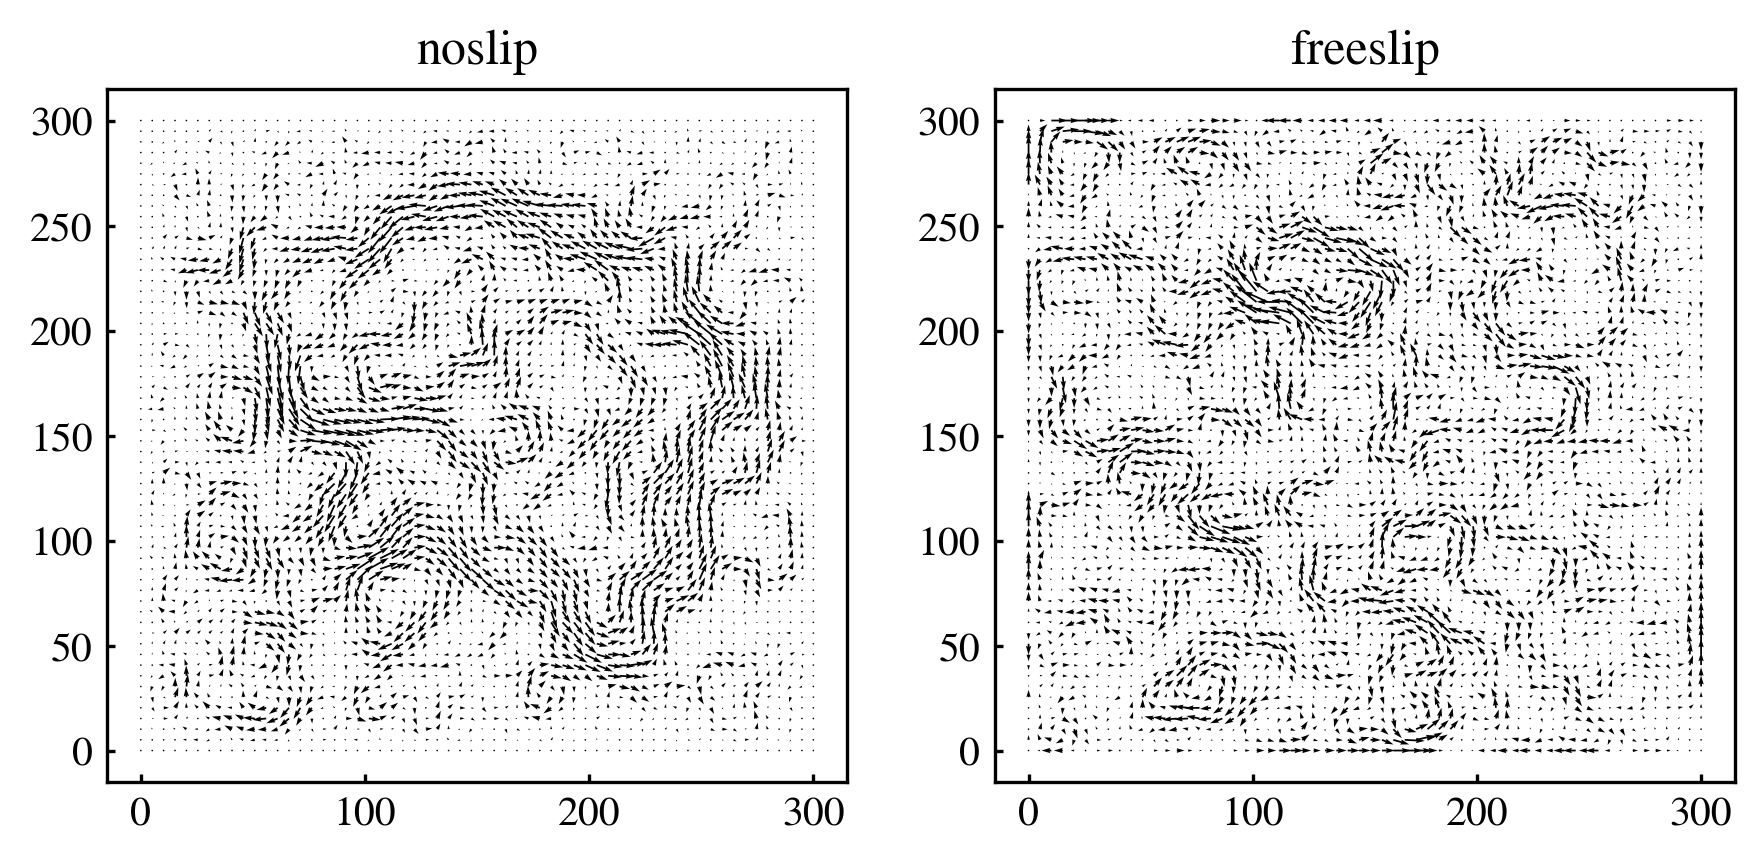

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=300)
X, Y, U, V = interpolate_to_grid(v_ns[50], domain_ns, 5)
ax[0].quiver(X, Y, U, V)
ax[0].set_title("noslip")
X, Y, U, V = interpolate_to_grid(v_fs[50], domain_fs, 5)
ax[1].quiver(X, Y, U, V)
ax[1].set_title("freeslip")

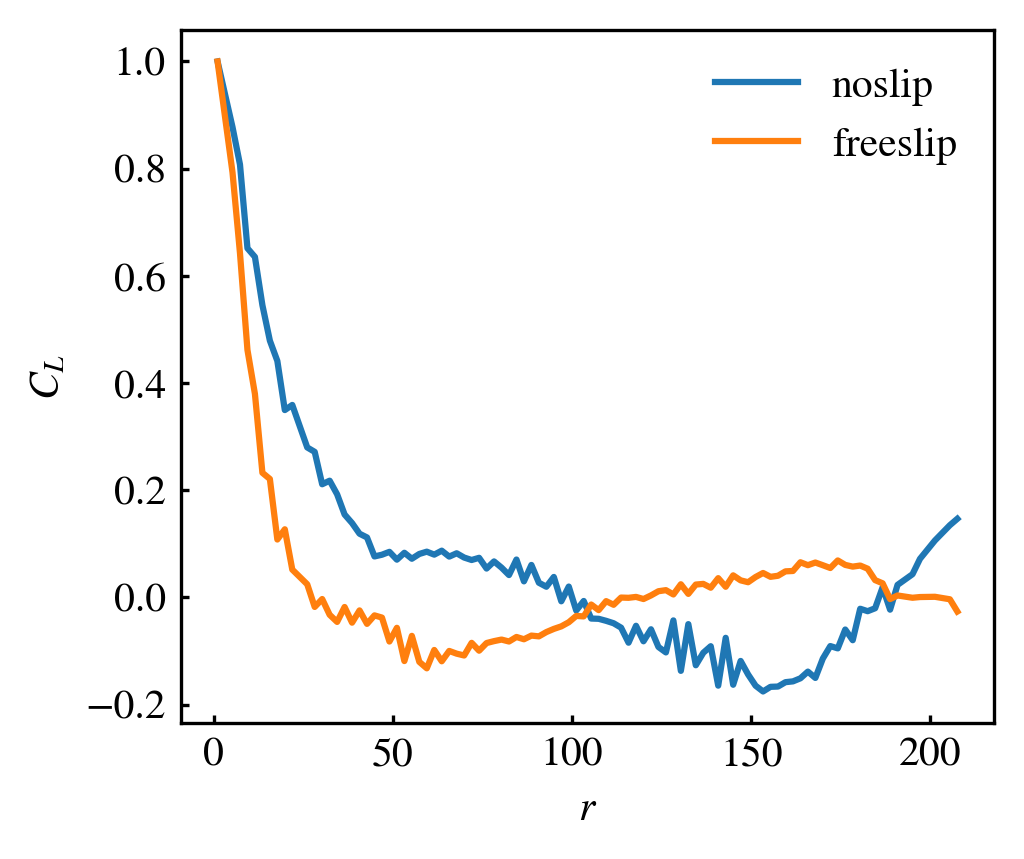

In [52]:
X, Y, U, V = interpolate_to_grid(v_ns[50], domain_ns, 5)
cln, vacfn = corr_length(X, Y, U, V)
X, Y, U, V = interpolate_to_grid(v_fs[50], domain_ns, 5)
clf, vacff = corr_length(X, Y, U, V)
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)
ax.plot(vacfn.R, vacfn.C, label="noslip")
ax.plot(vacff.R, vacff.C, label="freeslip")
ax.set_xlabel("$r$")
ax.set_ylabel("$C_L$")
ax.legend(frameon=False)

It's not super clear from the quiver plot that how different the two boundary conditions are. From the correlation length analysis, however, it is evident that noslip boundary has a longer correlation length. Direct observation of more velocity videos suggests that freeslip boundary is more likely to give rise to "pulsating" flows, while the flow field with noslip boundary tend to be more stable. 

## 7 Channel width 

Now that we know active turbulence arises in larger systems, we can set off to test different channel geometries. The key information we got from the tests are: (i) no-slip boundary gives more physical flows; (ii) the correlation length of velocity field is typically around 20; (iii) the solution is stable for mesh size around 3; (iv) for mesh away from channel, the size can be even coarser (~6).

With these information, we can start our test. Here, the tooth height $w$ will range from 10 to 30, while the height of tooth is fixed at 10. The number of ratchet will be fixed at 4.

## 8 Mesh resolution

The results from Q tensor correlation length suggest that the correlation is close to the length of the mesh size. That side, the correlation measured cannot be trusted because the mesh is too coarse. The correlation length is within one mesh size. 

In this section, we test a smaller mesh, with finer resolution. The plan is to test a square of 40x40, with mesh size ranging from 0.5 to 1.

In [9]:
folder = Path("/home/zhengyangliu/Documents/RATSIM/mesh_resolution")
save_folder = folder / "Correlation_length"
ress = [.5, .8, 1]
interval = 5
save_folder.mkdir(exist_ok=True)
dt = 0.1
for res in ress:
    v_list, domain = read_pvd(folder / f"RES={res:.1f}" / "results.pvd", "Q")
    t_list = []
    cl_list = []
    for i, v in enumerate(v_list):
        if i % interval == 0:
            X, Y, U, V = interpolate_to_grid(v, domain, .5)
            cl, vacf = corr_length(X, Y, U, V)
            print(i, cl, end="\r")
            t_list.append(dt*i)
            cl_list.append(cl)
    df = pd.DataFrame({"t": t_list, "cl": cl_list})
    df.to_hdf(save_folder / f"RES={res:.1f}.h5", "CL")

(0.0, 4.0)

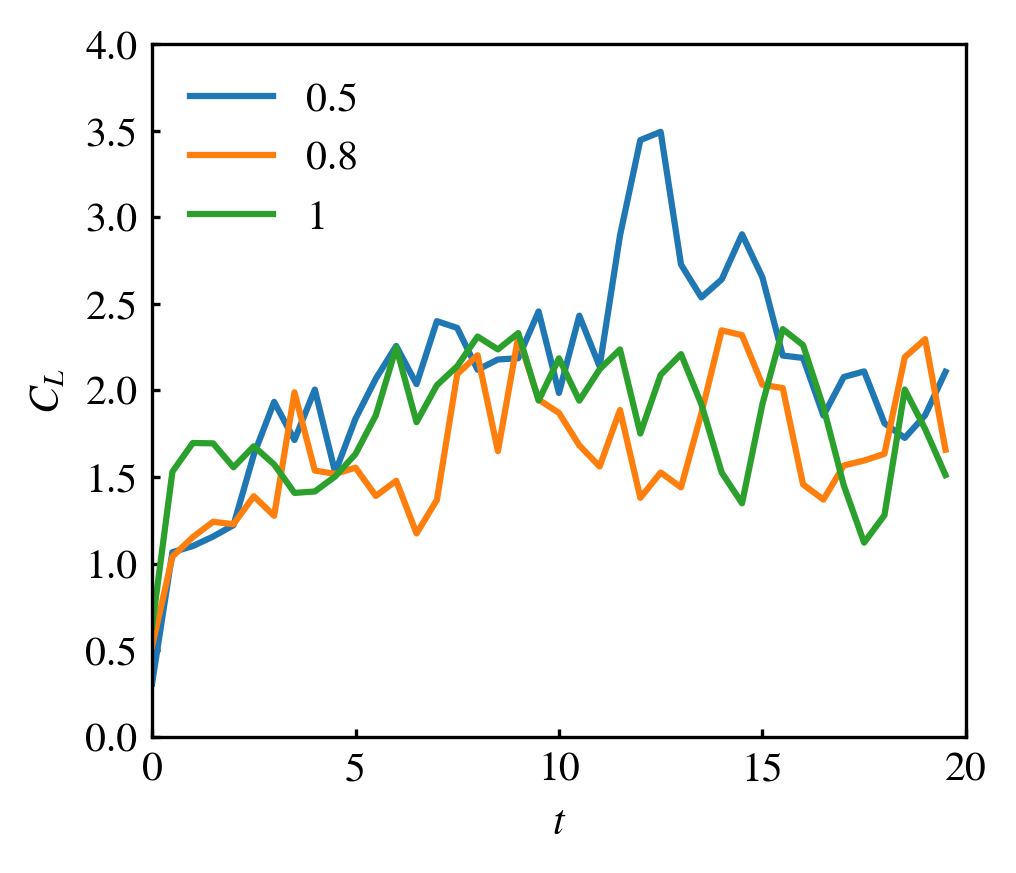

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)
for res in ress:
    df = pd.read_hdf(save_folder / f"RES={res:.1f}.h5")
    ax.plot(df.t, df.cl, "-", label=res)
ax.set_xlabel("$t$")
ax.set_ylabel("$C_L$")
ax.legend(frameon=False)
ax.set_xlim(0, 20)
ax.set_ylim(0, 4)

From the plot, we can read that for mesh resolution ranging from 0.5 to 1, the correlation length remains quite similar, with a low start, and a plateau value around 2. This observation confirms that the dx=0.5 suggested by Joshi et al. is indeed a good choice. We shall follow their choice in our mesh design and study the effect of the channel shape and length.

## 2 Boundary anchoring

Although the anchoring is set to be parallel, if the anchoring strength coefficient is set too small, the director tend to be perpendicular to the boudnaries. 

In this test, various anchoring strength, ranging from 

In [21]:
from pathlib import Path
import glob

STATUS_DIR = "~/Documents/RATSIM"
STATUS_DIR = Path(STATUS_DIR).expanduser().resolve()
status_files = glob.glob(str(STATUS_DIR / "**" / "log"), recursive=True)
status_files

['/home/zhengyangliu/Documents/RATSIM/alpha_length_scale/alpha=4/log',
 '/home/zhengyangliu/Documents/RATSIM/alpha_length_scale/alpha=32/log',
 '/home/zhengyangliu/Documents/RATSIM/alpha_length_scale/alpha=16/log',
 '/home/zhengyangliu/Documents/RATSIM/alpha_length_scale/alpha=8/log',
 '/home/zhengyangliu/Documents/RATSIM/alpha_length_scale/alpha=1/log',
 '/home/zhengyangliu/Documents/RATSIM/alpha_length_scale/alpha=2/log']

In [27]:
import time
time.time()

1750463906.9058473

In [28]:
time.time()

1750463913.080625

In [29]:
time.monotonic()

2250.081896024

In [30]:
time.monotonic()

2257.625838987

# Appendix

Info    : Reading 'mesh.msh'...
Info    : 53 entities
Info    : 2203 nodes
Info    : 4408 elements
Info    : Done reading 'mesh.msh'


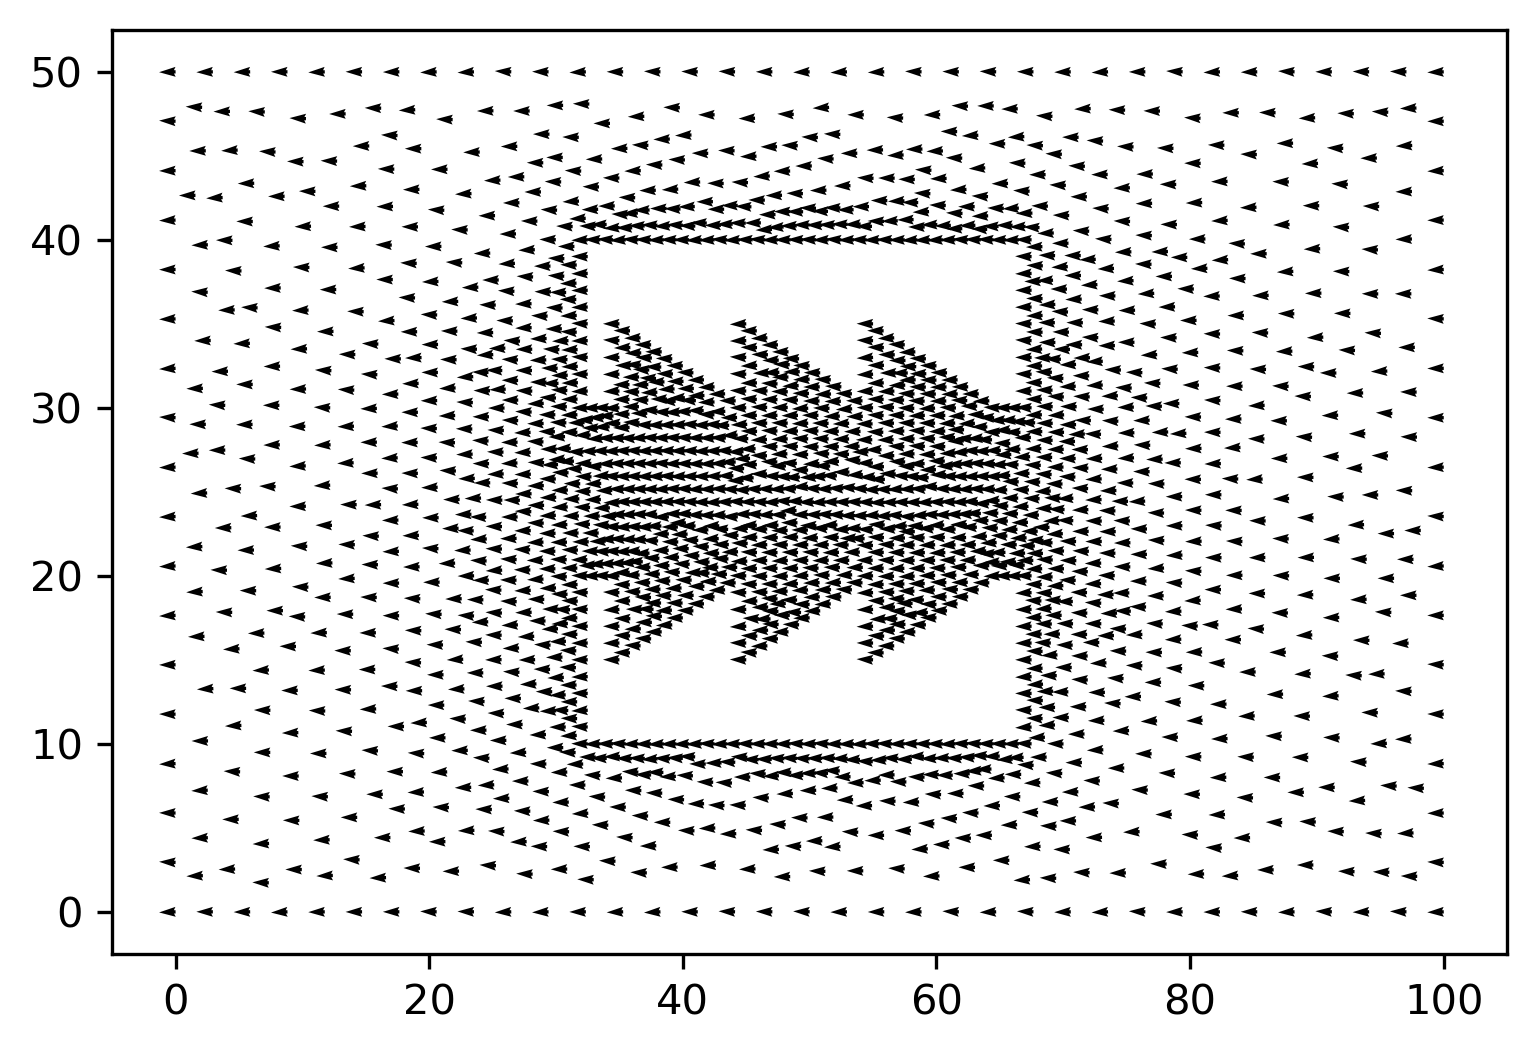

In [3]:
from dolfinx import io, fem
from mpi4py import MPI
from utils import *
import matplotlib.pyplot as plt

mesh_dir = "mesh.msh"
domain, cell_tags, facet_tags = io.gmshio.read_from_msh(mesh_dir, MPI.COMM_WORLD, 0, gdim=2)

V_Q = fem.functionspace(domain, ("Lagrange", 1, (2,2)))
Q = fem.Function(V_Q)

Q_vals = initialize_Q(domain, .1)
Q.x.array[:] = Q_vals
d = Q2D(Q)

x = domain.geometry.x
plt.figure(figsize=(6,4), dpi=300)
plt.quiver(x[:, 0], x[:, 1], d[:, 0], d[:, 1])